In [1]:
!pip install cleverhans

     |████████████████████████████████| 204kB 9.7MB/s 
     |████████████████████████████████| 163kB 15.1MB/s 
     |████████████████████████████████| 51kB 7.8MB/s 


In [2]:
%tensorflow_version 1.5
import tensorflow as tf
tf.__version__
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.5`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [3]:
# pylint: disable=missing-docstring
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import logging
import numpy as np
from six.moves import xrange

from cleverhans.attacks import SaliencyMapMethod
from tensorflow.python.platform import flags
from cleverhans.dataset import MNIST
from cleverhans.loss import CrossEntropy
from cleverhans.utils import other_classes, set_log_level
from cleverhans.utils import pair_visual, grid_visual, AccuracyReport
from cleverhans.utils_tf import model_eval, model_argmax
from cleverhans.train import train

import functools

from cleverhans import initializers
from cleverhans.model import Model

import warnings
warnings.filterwarnings(action='ignore')

In [4]:
class myLeNet(Model):
  def __init__(self, scope, nb_classes, nb_filters, iteration, **kwargs):
    del kwargs
    Model.__init__(self, scope, nb_classes, locals())
    self.nb_filters = nb_filters
    self.iteration = iteration
    # Do a dummy run of fprop to make sure the variables are created from
    # the start
    self.fprop(tf.placeholder(tf.float32, [128, 28, 28, 1]))
    # Put a reference to the params in self so that the params get pickled
    self.params = self.get_params()

  def fprop(self, x, **kwargs):
    del kwargs
    my_conv = functools.partial(
        tf.layers.conv2d, activation='tanh',
        kernel_initializer=initializers.HeReLuNormalInitializer)
    with tf.variable_scope(self.scope, reuse=tf.AUTO_REUSE):
      for _ in range(self.iteration):
        x = my_conv(x, 6, 5, strides=1, padding='same')
        x = tf.compat.v1.keras.layers.MaxPool2D((2, 2), strides = (1, 1), padding='same')(x)
      x = my_conv(x, 6, 5, strides=1, padding='valid')
      x = tf.compat.v1.keras.layers.AveragePooling2D((2, 2), strides = (2, 2))(x)
      x = my_conv(x, 16, 5, strides=1, padding='valid')
      x = tf.compat.v1.keras.layers.AveragePooling2D((2, 2), strides = (2, 2))(x)
      x = tf.layers.flatten(x)
      x = tf.layers.dense(x, 120, activation='tanh')
      x = tf.layers.dense(x, 84, activation='tanh')
      logits = tf.layers.dense(x, self.nb_classes, activation='tanh', kernel_initializer=initializers.HeReLuNormalInitializer)
      return {self.O_LOGITS: logits,
              self.O_PROBS: tf.nn.softmax(logits=logits)}

In [5]:
FLAGS = flags.FLAGS

VIZ_ENABLED = True
NB_EPOCHS = 6
BATCH_SIZE = 128
LEARNING_RATE = .001
SOURCE_SAMPLES = 10


def mnist_tutorial_jsma(train_start=0, train_end=60000, test_start=0,
                        test_end=10000, viz_enabled=VIZ_ENABLED,
                        nb_epochs=NB_EPOCHS, batch_size=BATCH_SIZE,
                        source_samples=SOURCE_SAMPLES,
                        learning_rate=LEARNING_RATE):
  """
  MNIST tutorial for the Jacobian-based saliency map approach (JSMA)
  :param train_start: index of first training set example
  :param train_end: index of last training set example
  :param test_start: index of first test set example
  :param test_end: index of last test set example
  :param viz_enabled: (boolean) activate plots of adversarial examples
  :param nb_epochs: number of epochs to train model
  :param batch_size: size of training batches
  :param nb_classes: number of output classes
  :param source_samples: number of test inputs to attack
  :param learning_rate: learning rate for training
  :return: an AccuracyReport object
  """
  # Object used to keep track of (and return) key accuracies
  report = AccuracyReport()

  # Set TF random seed to improve reproducibility
  tf.set_random_seed(1234)

  # Create TF session and set as Keras backend session
  sess = tf.Session()
  print("Created TensorFlow session.")

  set_log_level(logging.DEBUG)

  # Get MNIST test data
  mnist = MNIST(train_start=train_start, train_end=train_end,
                test_start=test_start, test_end=test_end)
  x_train, y_train = mnist.get_set('train')
  x_test, y_test = mnist.get_set('test')
  
  # Obtain Image Parameters
  img_rows, img_cols, nchannels = x_train.shape[1:4]
  nb_classes = y_train.shape[1]

  # Define input TF placeholder
  x = tf.placeholder(tf.float32, shape=(None, img_rows, img_cols,
                                        nchannels))
  y = tf.placeholder(tf.float32, shape=(None, nb_classes))

  nb_filters = 64
  # Define TF model graph
  model = myLeNet('model1', nb_classes, nb_filters, 40)
  preds = model.get_logits(x)
  loss = CrossEntropy(model, smoothing=0.1)
  print("Defined TensorFlow model graph.")

  ###########################################################################
  # Training the model using TensorFlow
  ###########################################################################

  # Train an MNIST model
  train_params = {
      'nb_epochs': nb_epochs,
      'batch_size': batch_size,
      'learning_rate': learning_rate
  }
  sess.run(tf.global_variables_initializer())
  rng = np.random.RandomState([2020, 12, 15])
  train(sess, loss, x_train, y_train, args=train_params, rng=rng)

  # Evaluate the accuracy of the MNIST model on legitimate test examples
  eval_params = {'batch_size': batch_size}
  accuracy = model_eval(sess, x, y, preds, x_test, y_test, args=eval_params)
  assert x_test.shape[0] == test_end - test_start, x_test.shape
  print('Test accuracy on legitimate test examples: {0}'.format(accuracy))
  report.clean_train_clean_eval = accuracy

  ###########################################################################
  # Craft adversarial examples using the Jacobian-based saliency map approach
  ###########################################################################
  print('Crafting ' + str(source_samples) + ' * ' + str(nb_classes - 1) +
        ' adversarial examples')

  # Keep track of success (adversarial example classified in target)
  results = np.zeros((nb_classes, source_samples), dtype='i')

  # Rate of perturbed features for each test set example and target class
  perturbations = np.zeros((nb_classes, source_samples), dtype='f')

  # Initialize our array for grid visualization
  grid_shape = (nb_classes, nb_classes, img_rows, img_cols, nchannels)
  grid_viz_data = np.zeros(grid_shape, dtype='f')

  # Instantiate a SaliencyMapMethod attack object
  jsma = SaliencyMapMethod(model, sess=sess)
  jsma_params = {'theta': 1., 'gamma': 0.1,
                 'clip_min': 0., 'clip_max': 1.,
                 'y_target': None}

  figure = None
  # Loop over the samples we want to perturb into adversarial examples
  sample_ind = 300
  attacked_classes = []
  num = 0
  while num < 10:
    current_class = int(np.argmax(y_test[sample_ind]))
    
    # If current class is already attacked
    if current_class in attacked_classes:
      sample_ind += 1
      continue
    
    print('--------------------------------------')
    print('Attacking input %i/%i' % (num + 1, source_samples))
    attacked_classes.append(current_class)
    sample = x_test[sample_ind:(sample_ind + 1)]

    # We want to find an adversarial example for each possible target class
    # (i.e. all classes that differ from the label given in the dataset)
    target_classes = other_classes(nb_classes, current_class)

    # For the grid visualization, keep original images along the diagonal
    grid_viz_data[current_class, current_class, :, :, :] = np.reshape(
        sample, (img_rows, img_cols, nchannels))

    # Loop over all target classes
    for target in target_classes:
      print('Generating adv. example for target class %i' % target)

      # This call runs the Jacobian-based saliency map approach
      one_hot_target = np.zeros((1, nb_classes), dtype=np.float32)
      one_hot_target[0, target] = 1
      jsma_params['y_target'] = one_hot_target
      adv_x = jsma.generate_np(sample, **jsma_params)

      # Check if success was achieved
      res = int(model_argmax(sess, x, preds, adv_x) == target)

      # Compute number of modified features
      adv_x_reshape = adv_x.reshape(-1)
      test_in_reshape = x_test[sample_ind].reshape(-1)
      nb_changed = np.where(adv_x_reshape != test_in_reshape)[0].shape[0]
      percent_perturb = float(nb_changed) / adv_x.reshape(-1).shape[0]

      # Display the original and adversarial images side-by-side
      if viz_enabled:
        figure = pair_visual(
            np.reshape(sample, (img_rows, img_cols, nchannels)),
            np.reshape(adv_x, (img_rows, img_cols, nchannels)), figure)

      # Add our adversarial example to our grid data
      grid_viz_data[target, current_class, :, :, :] = np.reshape(
          adv_x, (img_rows, img_cols, nchannels))

      # Update the arrays for later analysis
      results[target, num] = res
      perturbations[target, num] = percent_perturb
    
    num += 1
  
  print('--------------------------------------')

  print('Test accuracy on legitimate test examples: {0}'.format(accuracy))

  # Compute the number of adversarial examples that were successfully found
  nb_targets_tried = ((nb_classes - 1) * source_samples)
  succ_rate = float(np.sum(results)) / nb_targets_tried
  print('Avg. rate of successful adv. examples {0:.4f}'.format(succ_rate))
  report.clean_train_adv_eval = 1. - succ_rate

  # Compute the average distortion introduced by the algorithm
  percent_perturbed = np.mean(perturbations[np.where(perturbations!=0)])
  print('Avg. rate of perturbed features {0:.4f}'.format(percent_perturbed))

  # Compute the average distortion introduced for successful samples only
  percent_perturb_succ = np.mean(perturbations[np.where(perturbations!=0)] * (results[np.where(perturbations!=0)] == 1))
  print('Avg. rate of perturbed features for successful '
        'adversarial examples {0:.4f}'.format(percent_perturb_succ))

  # Close TF session
  sess.close()

  # Finally, block & display a grid of all the adversarial examples
  if viz_enabled:
    import matplotlib.pyplot as plt
    plt.close(figure)
    _ = grid_visual(grid_viz_data)

  return report

In [6]:
def main(argv=None):
  from cleverhans_tutorials import check_installation
#   check_installation(__file__)

  mnist_tutorial_jsma(viz_enabled=FLAGS.viz_enabled,
                      nb_epochs=FLAGS.nb_epochs,
                      batch_size=FLAGS.batch_size,
                      source_samples=FLAGS.source_samples,
                      learning_rate=FLAGS.learning_rate)

Created TensorFlow session.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.


W1213 03:43:21.053331 140212592293760 deprecation.py:323] From <ipython-input-4-45c7a59ea163>:20: conv2d (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.


Instructions for updating:
Please use `layer.__call__` method instead.


W1213 03:43:21.059718 140212592293760 deprecation.py:323] From /tensorflow-1.15.2/python3.6/tensorflow_core/python/layers/convolutional.py:424: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


W1213 03:43:21.067235 140212592293760 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/cleverhans/initializers.py:10: calling RandomNormal.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


W1213 03:43:21.072659 140212592293760 module_wrapper.py:139] From /usr/local/lib/python3.6/dist-packages/cleverhans/initializers.py:18: The name tf.rsqrt is deprecated. Please use tf.math.rsqrt instead.



W1213 03:43:21.100914 140212592293760 module_wrapper.py:139] From /usr/local/lib/python3.6/dist-packages/cleverhans/initializers.py:19: The name tf.random_normal is deprecated. Please use tf.random.normal instead.



Instructions for updating:
Use keras.layers.flatten instead.


W1213 03:43:21.899309 140212592293760 deprecation.py:323] From <ipython-input-4-45c7a59ea163>:27: flatten (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.flatten instead.


Instructions for updating:
Use keras.layers.Dense instead.


W1213 03:43:21.906347 140212592293760 deprecation.py:323] From <ipython-input-4-45c7a59ea163>:28: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.Dense instead.


W1213 03:43:21.950114 140212592293760 module_wrapper.py:139] From /usr/local/lib/python3.6/dist-packages/cleverhans/model.py:129: The name tf.get_collection is deprecated. Please use tf.compat.v1.get_collection instead.



Defined TensorFlow model graph.



W1213 03:43:29.815353 140212592293760 module_wrapper.py:139] From /usr/local/lib/python3.6/dist-packages/cleverhans/train.py:117: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.



Instructions for updating:
dim is deprecated, use axis instead


W1213 03:43:30.070924 140212592293760 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/cleverhans/compat.py:124: calling softmax_cross_entropy_with_logits_v2_helper (from tensorflow.python.ops.nn_ops) with dim is deprecated and will be removed in a future version.
Instructions for updating:
dim is deprecated, use axis instead


num_devices:  1



W1213 03:43:31.146414 140212592293760 module_wrapper.py:139] From /usr/local/lib/python3.6/dist-packages/cleverhans/utils_tf.py:60: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



W1213 03:43:31.148756 140212592293760 module_wrapper.py:139] From /usr/local/lib/python3.6/dist-packages/cleverhans/utils_tf.py:63: The name tf.is_variable_initialized is deprecated. Please use tf.compat.v1.is_variable_initialized instead.



W1213 03:43:31.608426 140212592293760 module_wrapper.py:139] From /usr/local/lib/python3.6/dist-packages/cleverhans/utils_tf.py:72: The name tf.variables_initializer is deprecated. Please use tf.compat.v1.variables_initializer instead.

[INFO 2020-12-13 03:43:52,114 cleverhans] Epoch 0 took 20.171465158462524 seconds
I1213 03:43:52.114244 140212592293760 train.py:257] Epoch 0 took 20.171465158462524 seconds
[INFO 2020-12-13 03:44:05,100 cleverhans] Epoch 1 took 12.891528844833374 seconds
I1213 03:44:05.100048 140212592293760 train.py:257] Epoch 1 took 12.891528844833374 seconds
[INFO 2020-12-13 03:44:18,183 cleverhans] Epoch 2 took 13.011541843414307 seconds
I1213 03:44:18.183730 140212592293760 train.py:257] Epoch 2 took 13.011541843414307 seconds
[INFO 2020-12-13 03:44:31,271 cleverhans] Epoch 3 took 13.019952297210693 seconds
I1213 03:44:31.271737 140212592293760 train.py:257] Epoch 3 took 13.019952297210693 seconds
[INFO 2020-12-13 03:44:44,386 cleverhans] Epoch 4 took 13.047954559

Crafting 10 * 9 adversarial examples
--------------------------------------
Attacking input 1/10
Generating adv. example for target class 0



W1213 03:44:58.811993 140212592293760 module_wrapper.py:139] From /usr/local/lib/python3.6/dist-packages/cleverhans/utils_tf.py:624: The name tf.assert_greater_equal is deprecated. Please use tf.compat.v1.assert_greater_equal instead.



W1213 03:44:58.829071 140212592293760 module_wrapper.py:139] From /usr/local/lib/python3.6/dist-packages/cleverhans/utils_tf.py:615: The name tf.assert_less_equal is deprecated. Please use tf.compat.v1.assert_less_equal instead.



W1213 03:45:01.181277 140212592293760 module_wrapper.py:139] From /usr/local/lib/python3.6/dist-packages/cleverhans/attacks_tf.py:446: The name tf.mod is deprecated. Please use tf.math.mod instead.



W1213 03:45:01.188315 140212592293760 module_wrapper.py:139] From /usr/local/lib/python3.6/dist-packages/cleverhans/attacks_tf.py:447: The name tf.floordiv is deprecated. Please use tf.math.floordiv instead.



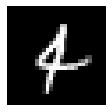

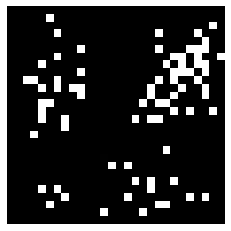

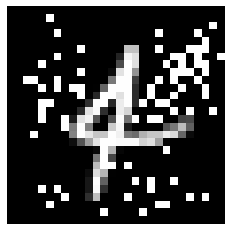

Generating adv. example for target class 1


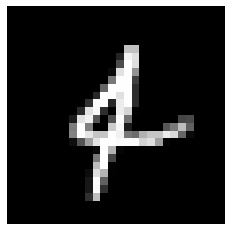

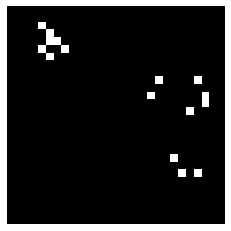

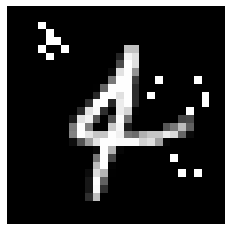

Generating adv. example for target class 2


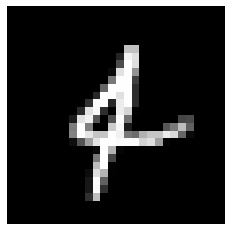

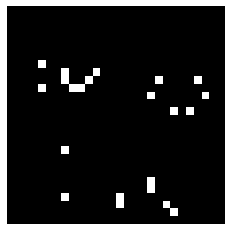

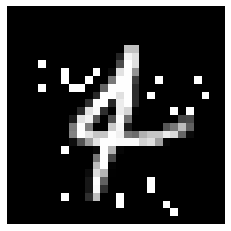

Generating adv. example for target class 3


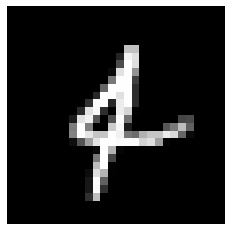

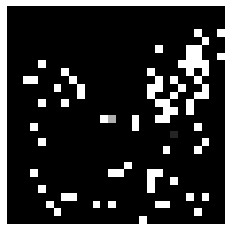

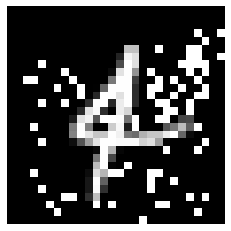

Generating adv. example for target class 5


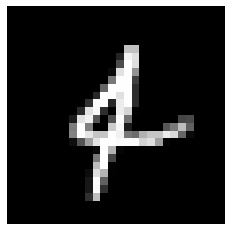

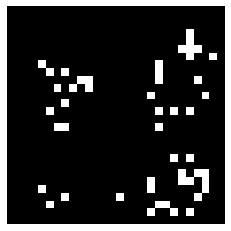

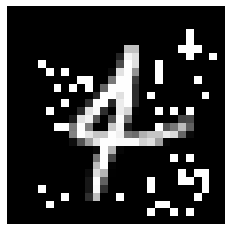

Generating adv. example for target class 6


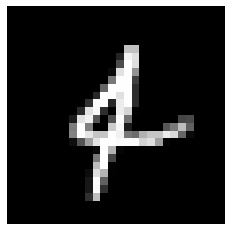

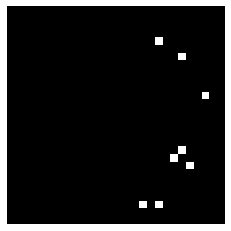

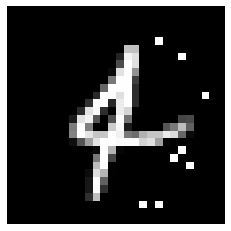

Generating adv. example for target class 7


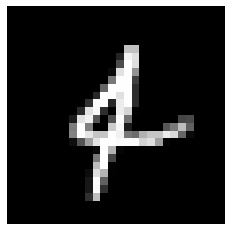

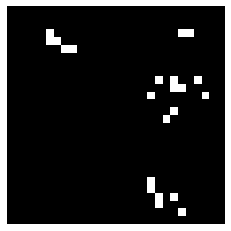

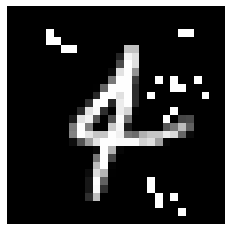

Generating adv. example for target class 8


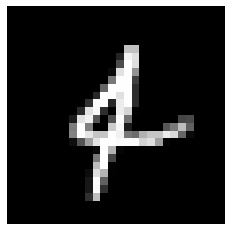

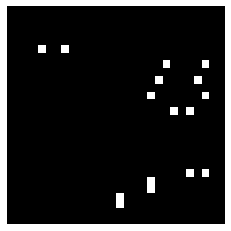

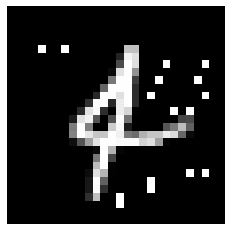

Generating adv. example for target class 9


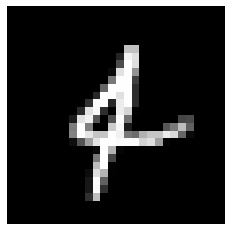

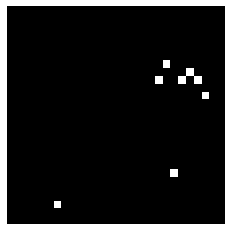

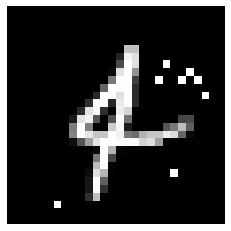

--------------------------------------
Attacking input 2/10
Generating adv. example for target class 0


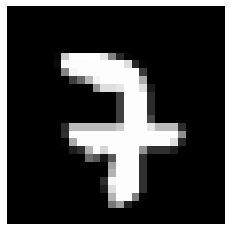

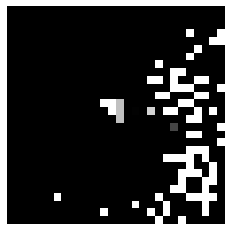

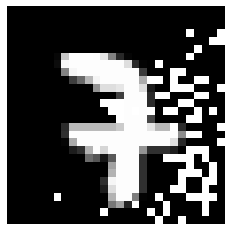

Generating adv. example for target class 1


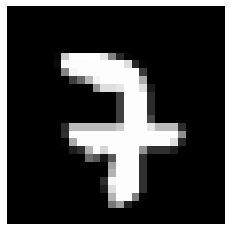

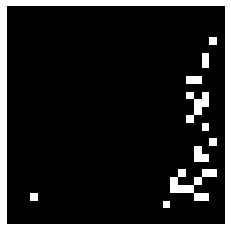

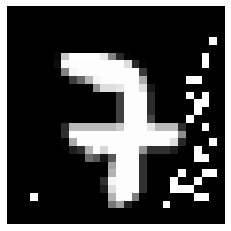

Generating adv. example for target class 2


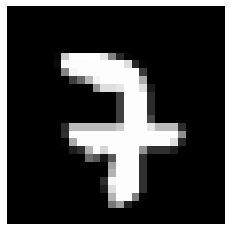

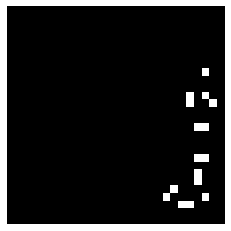

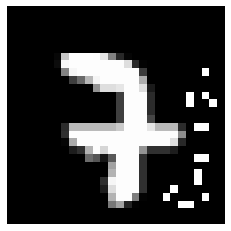

Generating adv. example for target class 3


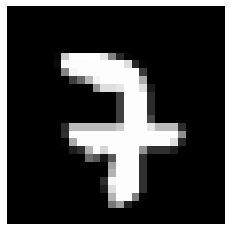

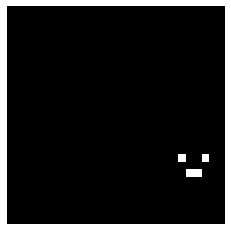

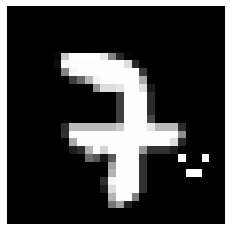

Generating adv. example for target class 4


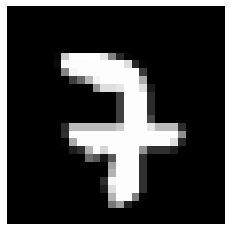

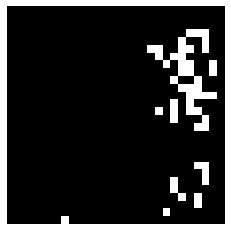

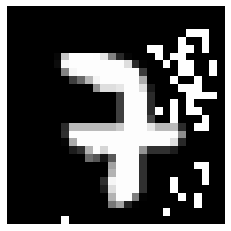

Generating adv. example for target class 5


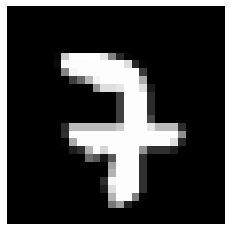

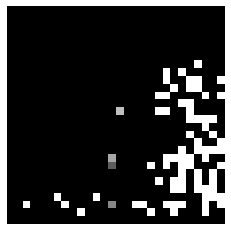

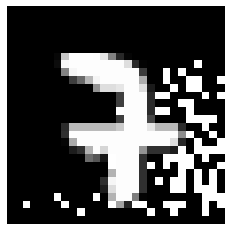

Generating adv. example for target class 6


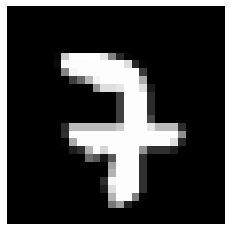

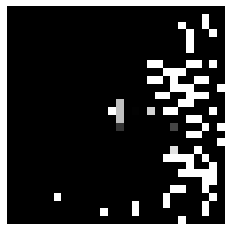

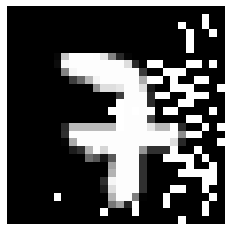

Generating adv. example for target class 8


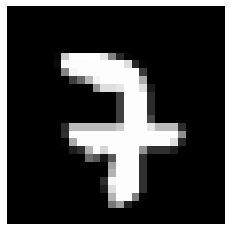

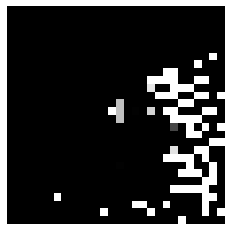

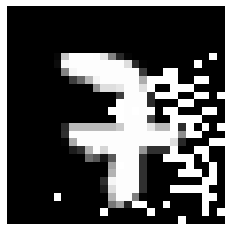

Generating adv. example for target class 9


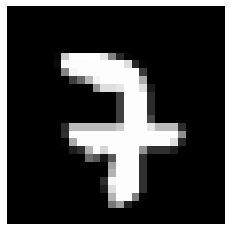

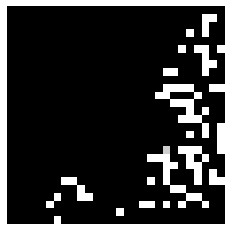

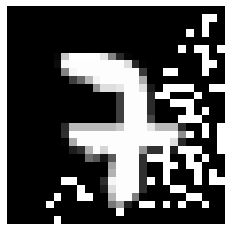

--------------------------------------
Attacking input 3/10
Generating adv. example for target class 0


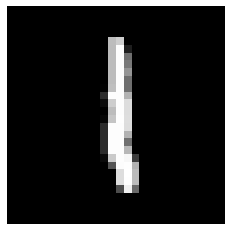

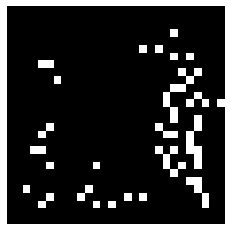

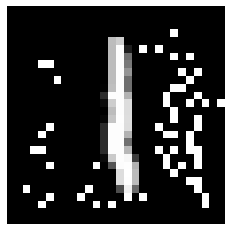

Generating adv. example for target class 2


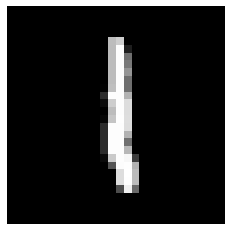

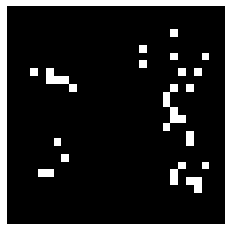

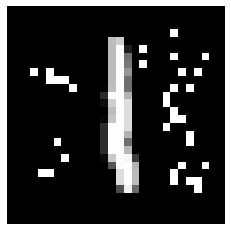

Generating adv. example for target class 3


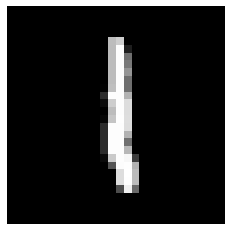

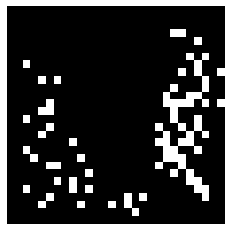

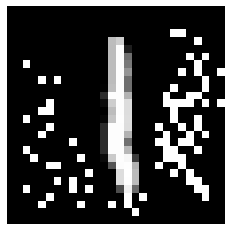

Generating adv. example for target class 4


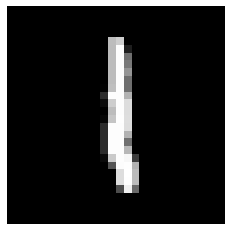

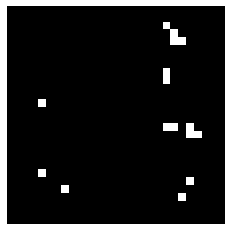

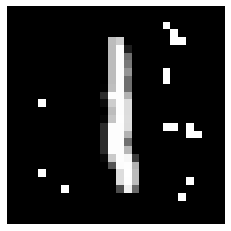

Generating adv. example for target class 5


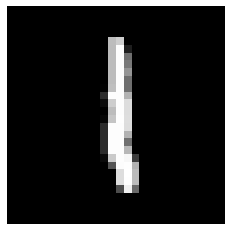

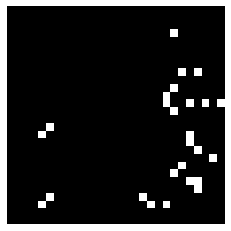

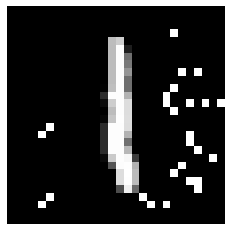

Generating adv. example for target class 6


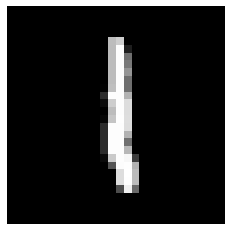

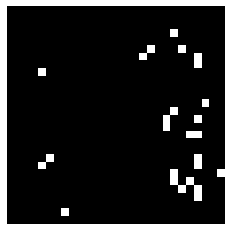

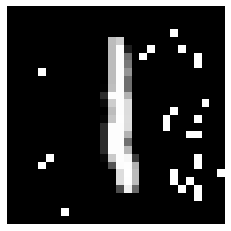

Generating adv. example for target class 7


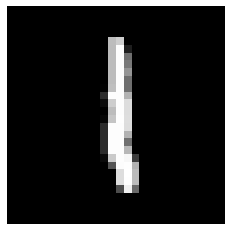

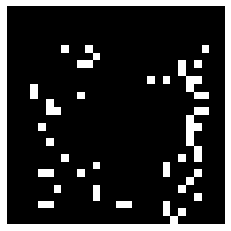

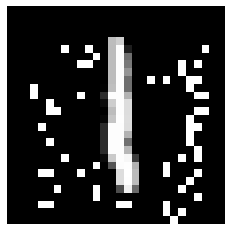

Generating adv. example for target class 8


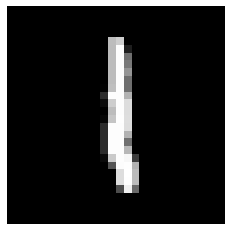

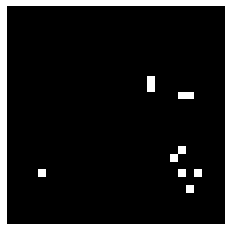

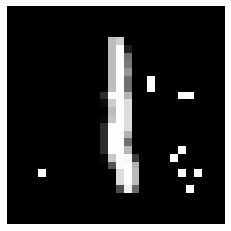

Generating adv. example for target class 9


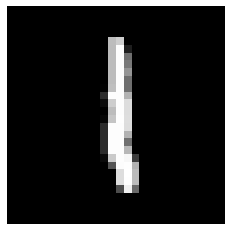

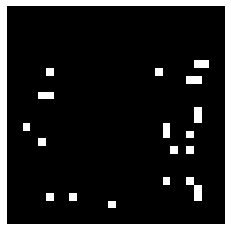

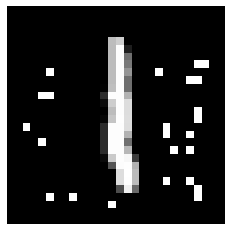

--------------------------------------
Attacking input 4/10
Generating adv. example for target class 0


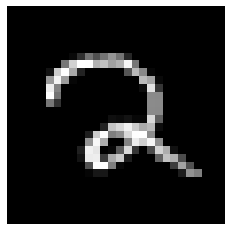

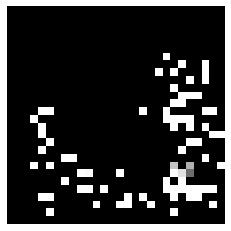

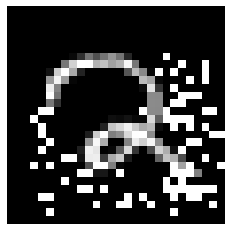

Generating adv. example for target class 1


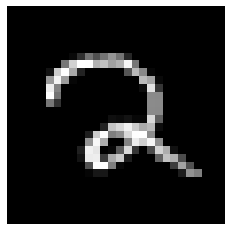

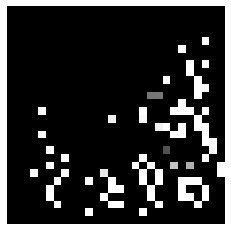

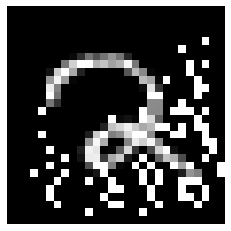

Generating adv. example for target class 3


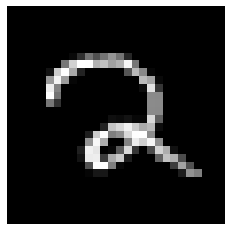

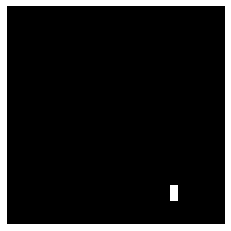

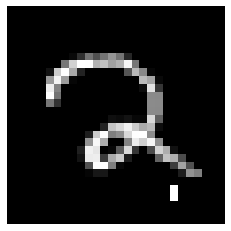

Generating adv. example for target class 4


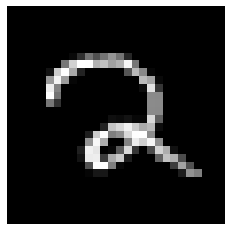

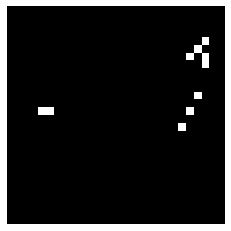

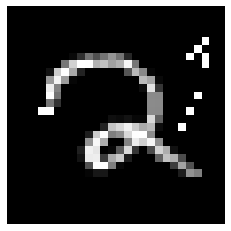

Generating adv. example for target class 5


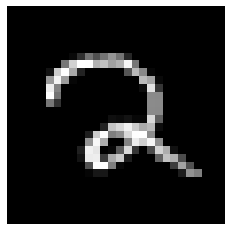

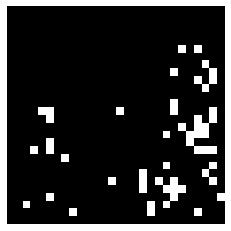

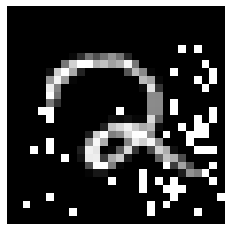

Generating adv. example for target class 6


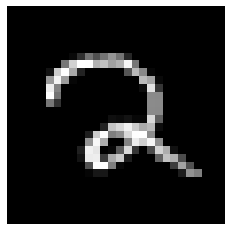

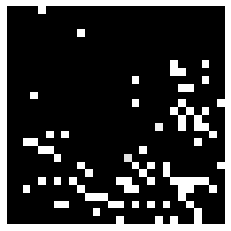

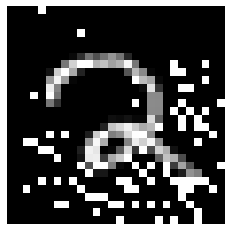

Generating adv. example for target class 7


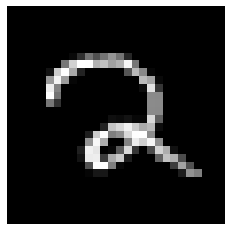

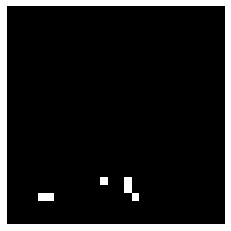

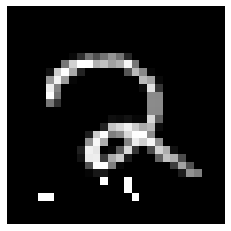

Generating adv. example for target class 8


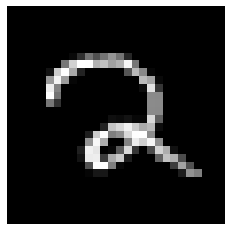

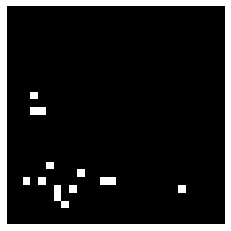

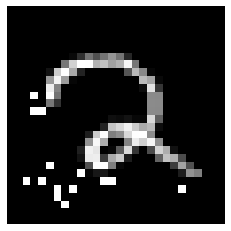

Generating adv. example for target class 9


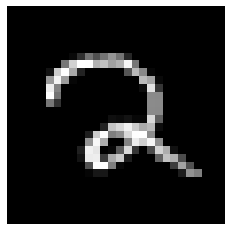

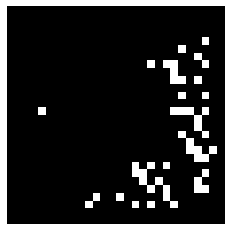

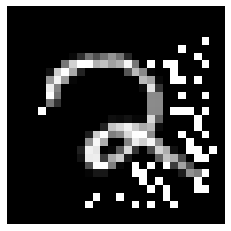

--------------------------------------
Attacking input 5/10
Generating adv. example for target class 1


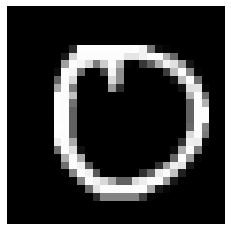

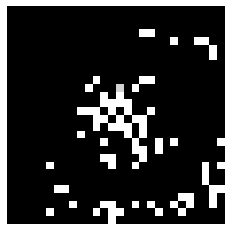

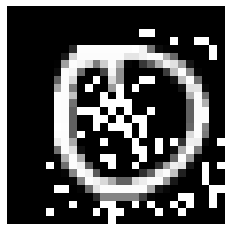

Generating adv. example for target class 2


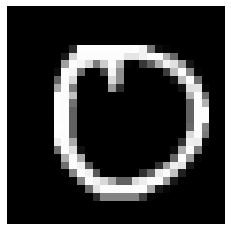

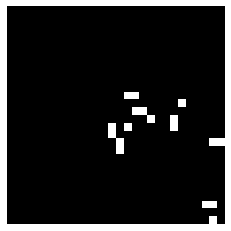

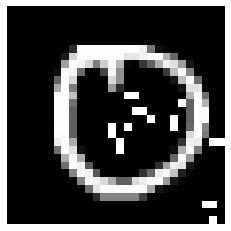

Generating adv. example for target class 3


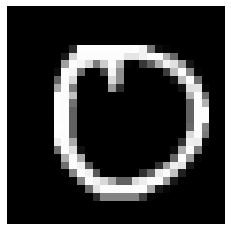

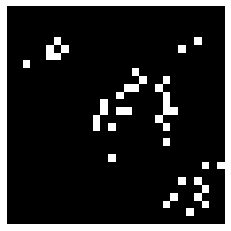

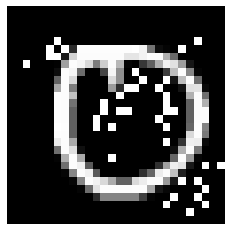

Generating adv. example for target class 4


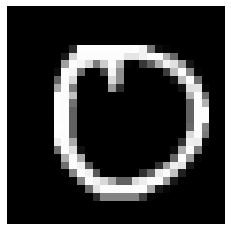

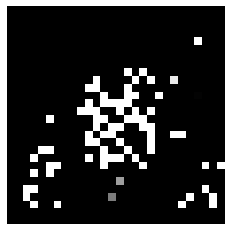

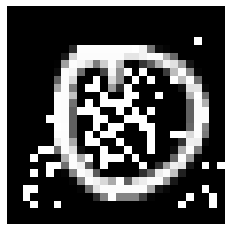

Generating adv. example for target class 5


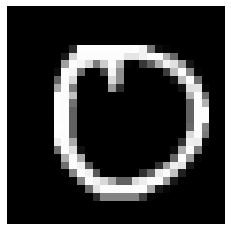

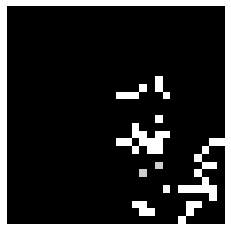

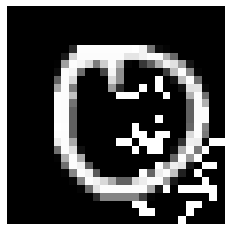

Generating adv. example for target class 6


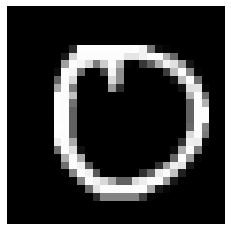

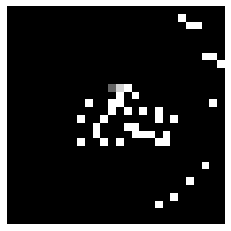

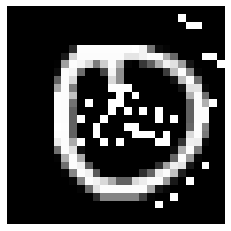

Generating adv. example for target class 7


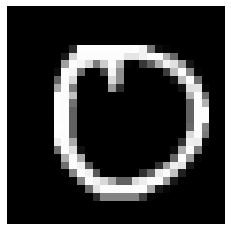

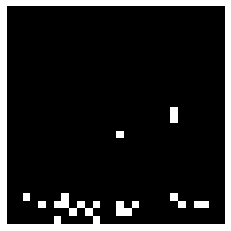

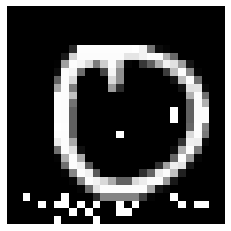

Generating adv. example for target class 8


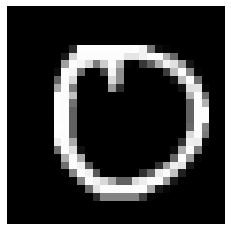

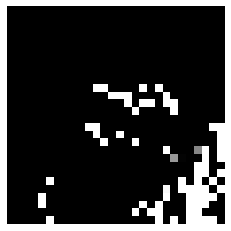

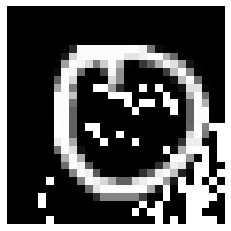

Generating adv. example for target class 9


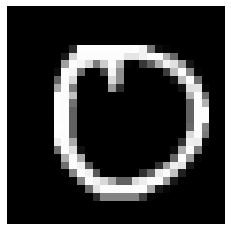

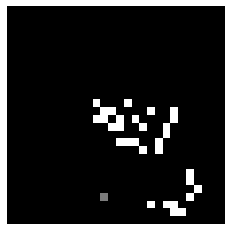

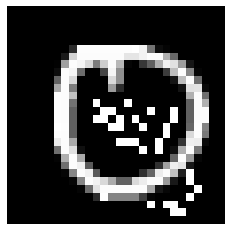

--------------------------------------
Attacking input 6/10
Generating adv. example for target class 0


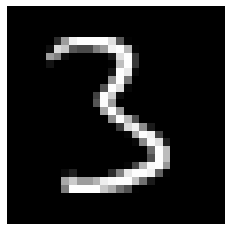

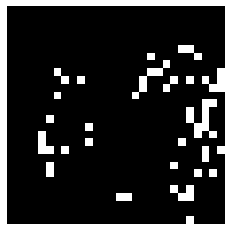

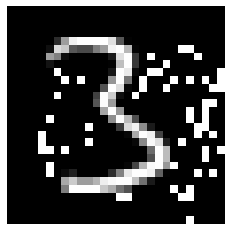

Generating adv. example for target class 1


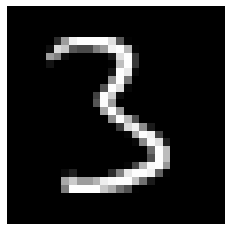

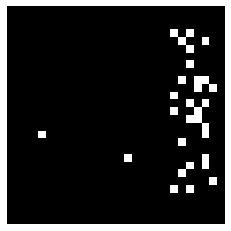

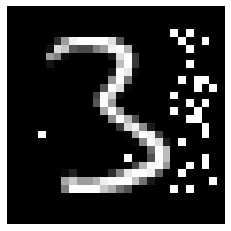

Generating adv. example for target class 2


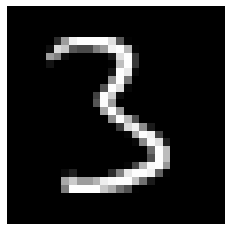

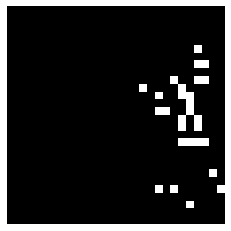

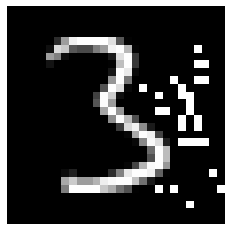

Generating adv. example for target class 4


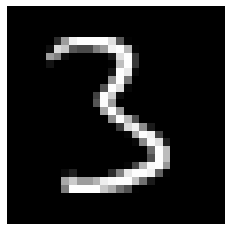

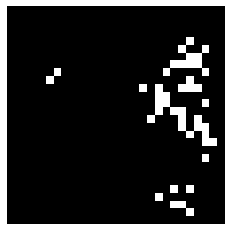

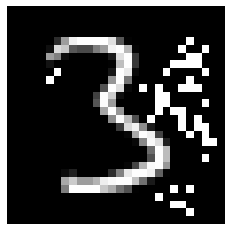

Generating adv. example for target class 5


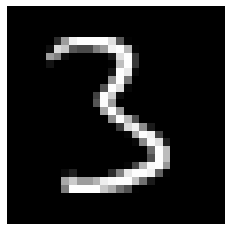

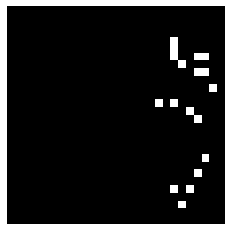

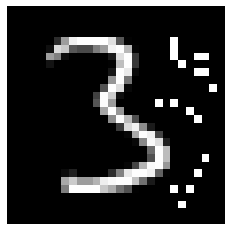

Generating adv. example for target class 6


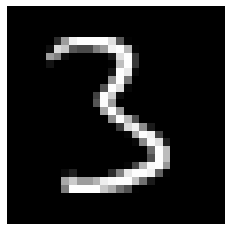

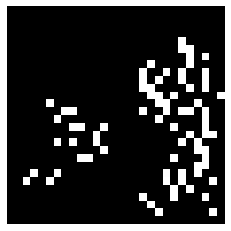

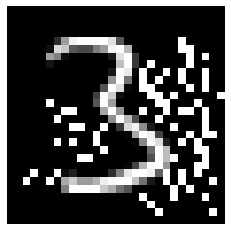

Generating adv. example for target class 7


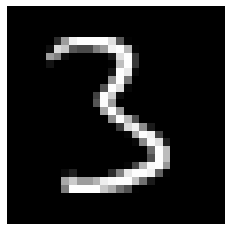

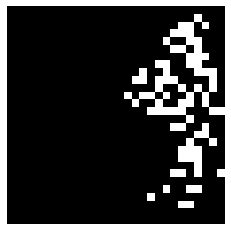

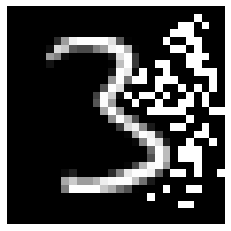

Generating adv. example for target class 8


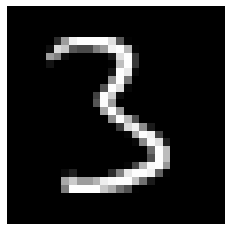

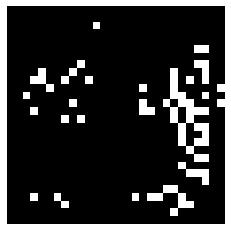

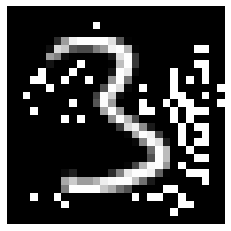

Generating adv. example for target class 9


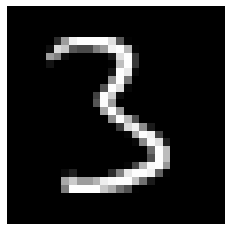

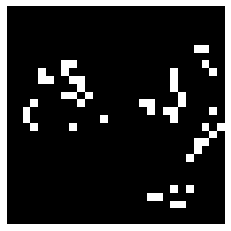

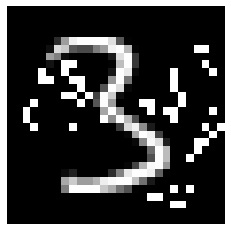

--------------------------------------
Attacking input 7/10
Generating adv. example for target class 0


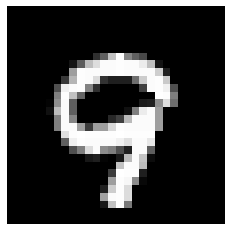

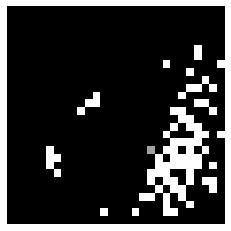

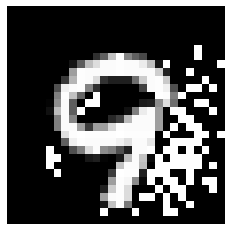

Generating adv. example for target class 1


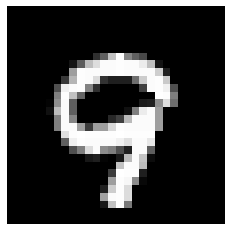

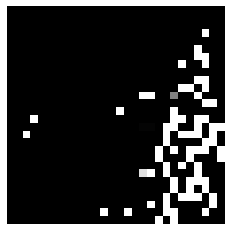

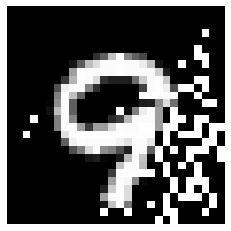

Generating adv. example for target class 2


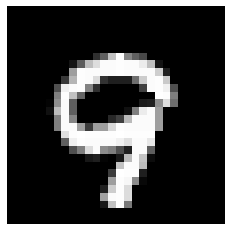

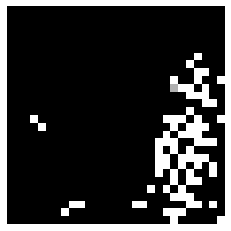

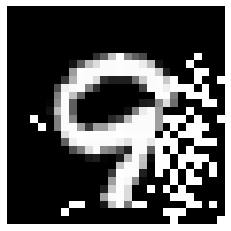

Generating adv. example for target class 3


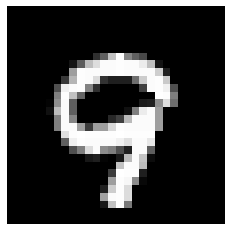

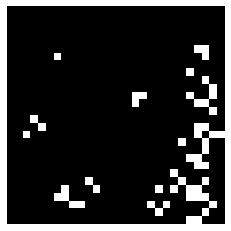

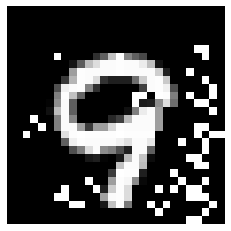

Generating adv. example for target class 4


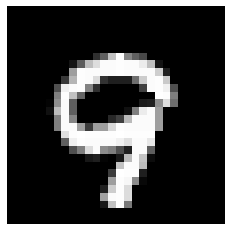

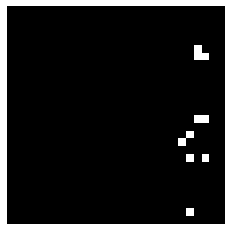

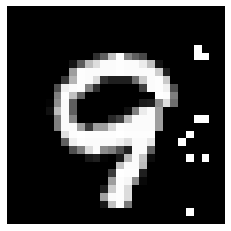

Generating adv. example for target class 5


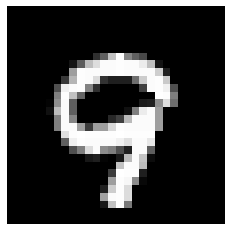

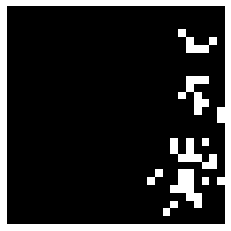

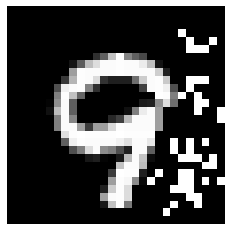

Generating adv. example for target class 6


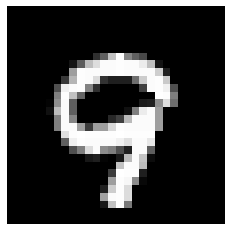

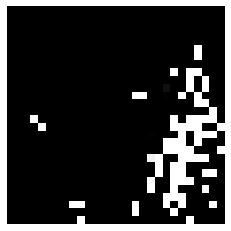

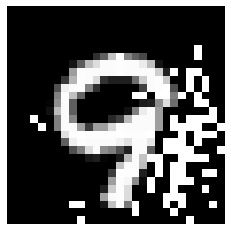

Generating adv. example for target class 7


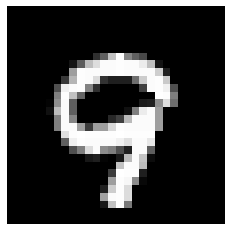

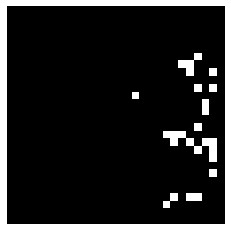

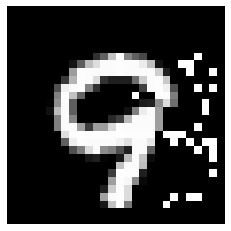

Generating adv. example for target class 8


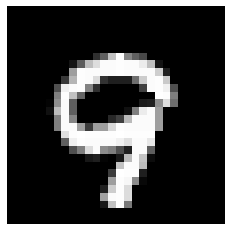

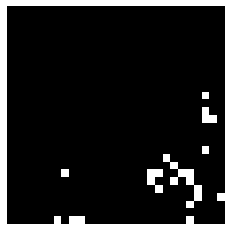

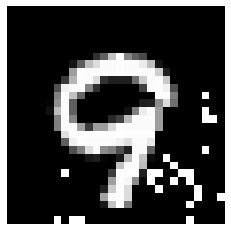

--------------------------------------
Attacking input 8/10
Generating adv. example for target class 0


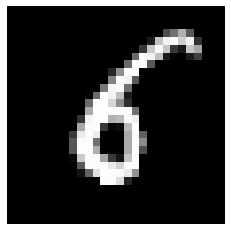

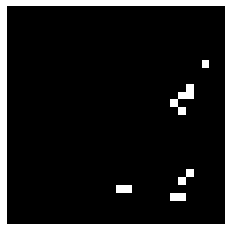

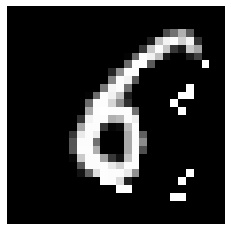

Generating adv. example for target class 1


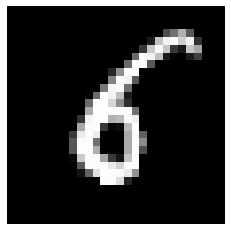

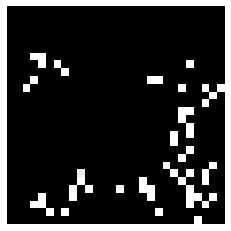

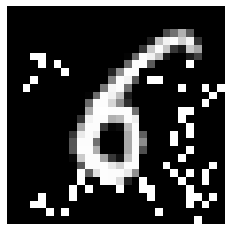

Generating adv. example for target class 2


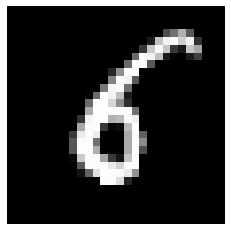

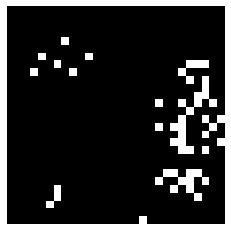

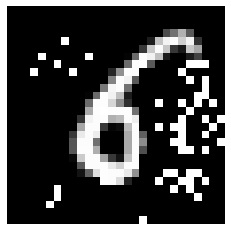

Generating adv. example for target class 3


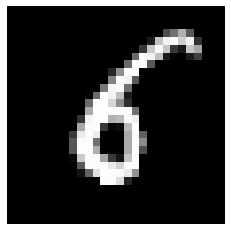

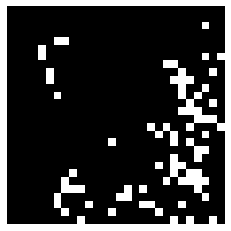

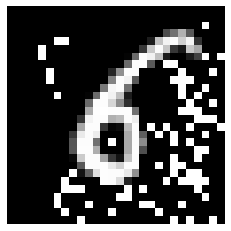

Generating adv. example for target class 4


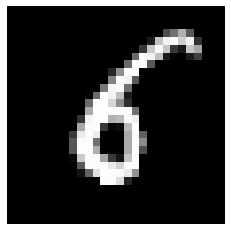

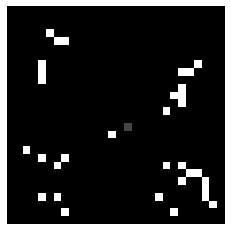

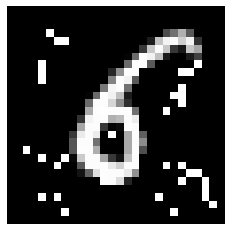

Generating adv. example for target class 5


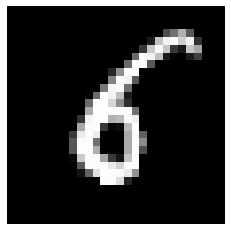

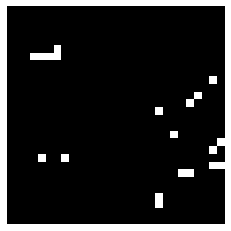

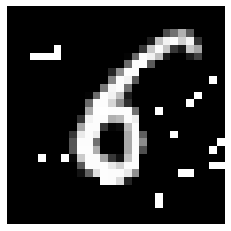

Generating adv. example for target class 7


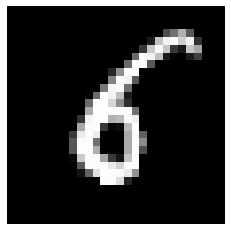

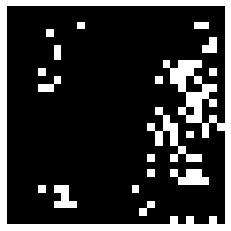

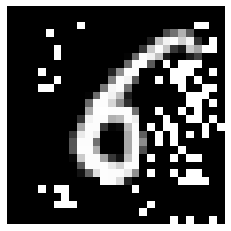

Generating adv. example for target class 8


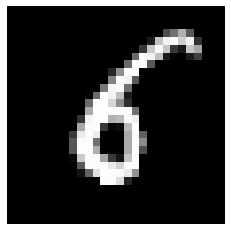

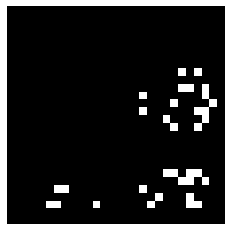

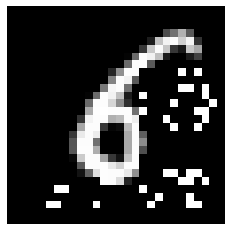

Generating adv. example for target class 9


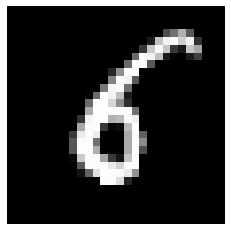

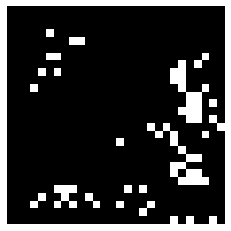

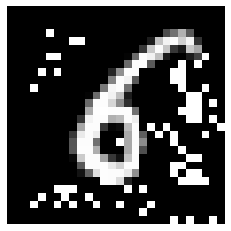

--------------------------------------
Attacking input 9/10
Generating adv. example for target class 0


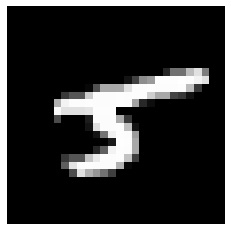

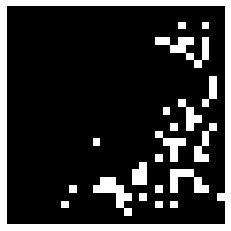

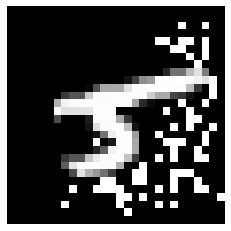

Generating adv. example for target class 1


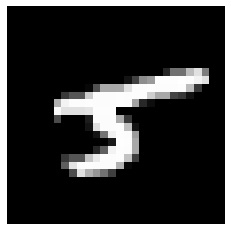

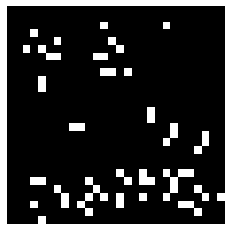

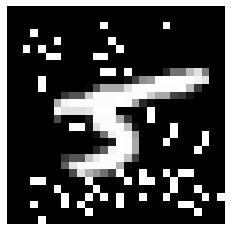

Generating adv. example for target class 2


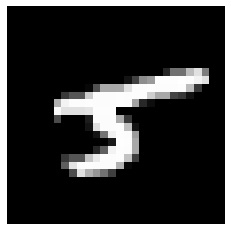

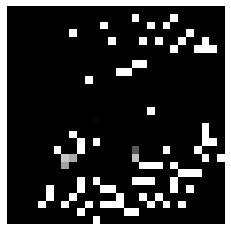

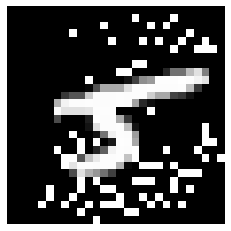

Generating adv. example for target class 3


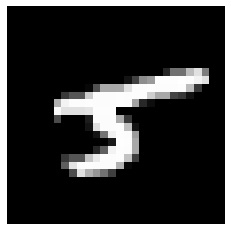

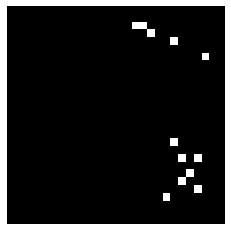

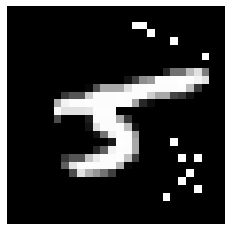

Generating adv. example for target class 4


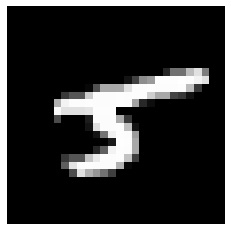

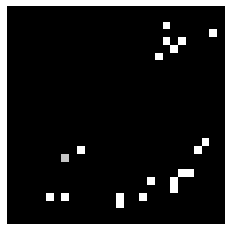

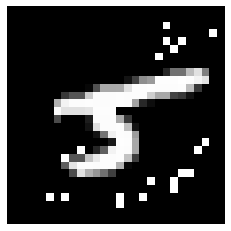

Generating adv. example for target class 6


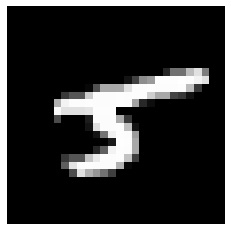

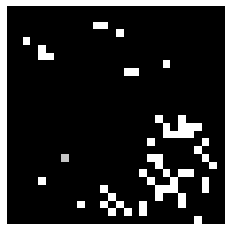

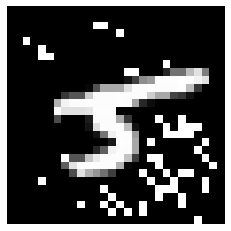

Generating adv. example for target class 7


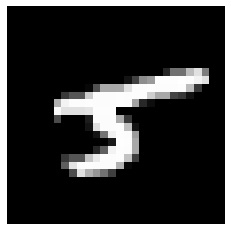

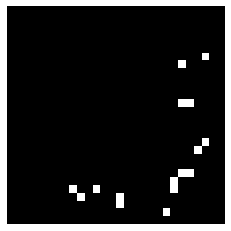

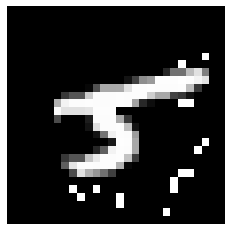

Generating adv. example for target class 8


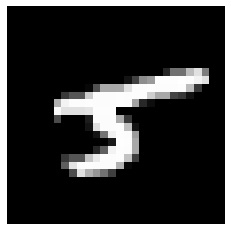

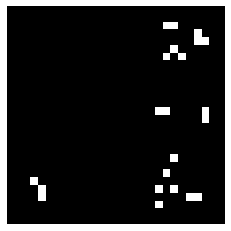

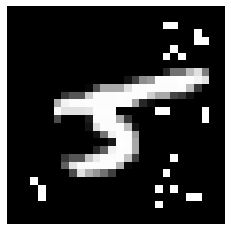

Generating adv. example for target class 9


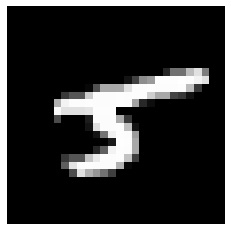

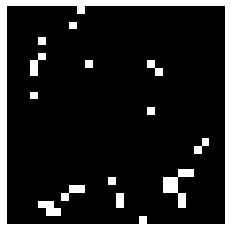

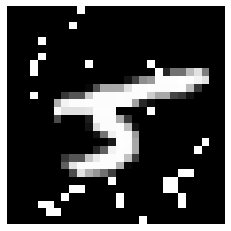

--------------------------------------
Attacking input 10/10
Generating adv. example for target class 0


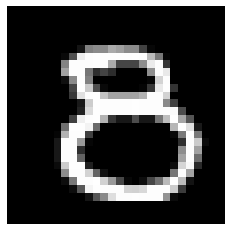

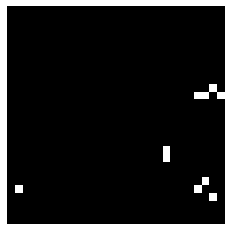

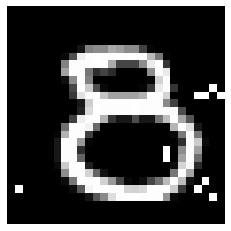

Generating adv. example for target class 1


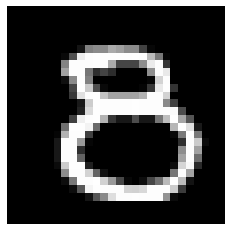

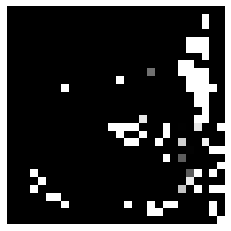

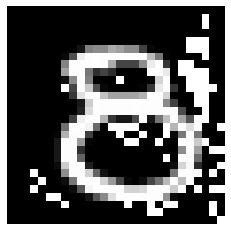

Generating adv. example for target class 2


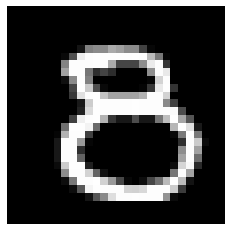

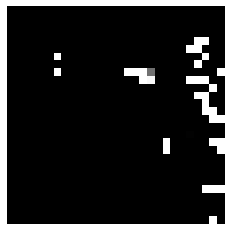

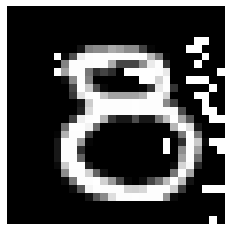

Generating adv. example for target class 3


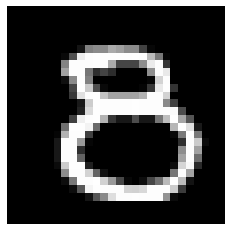

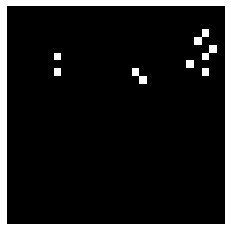

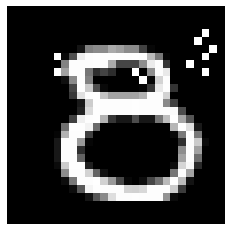

Generating adv. example for target class 4


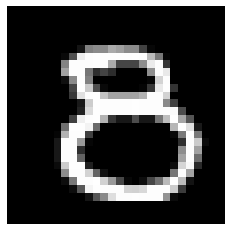

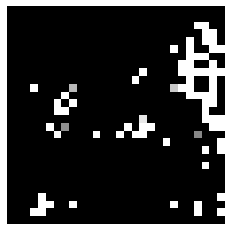

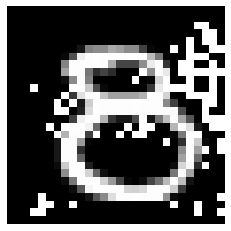

Generating adv. example for target class 5


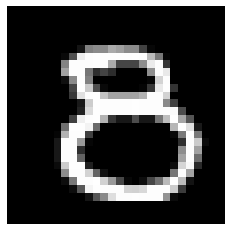

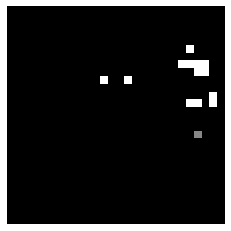

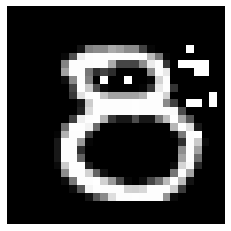

Generating adv. example for target class 6


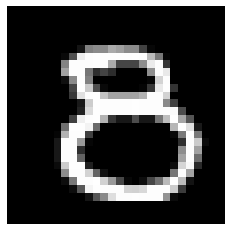

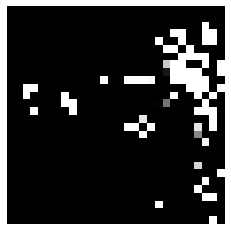

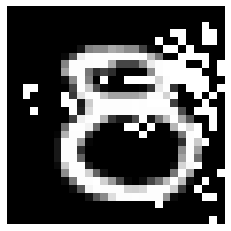

Generating adv. example for target class 7


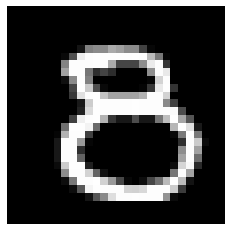

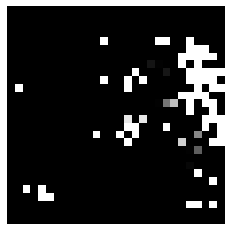

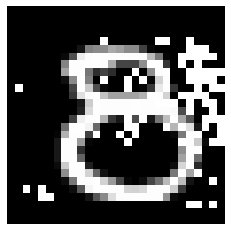

Generating adv. example for target class 9


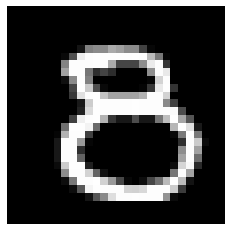

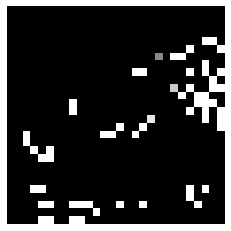

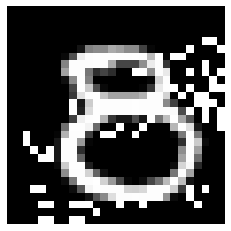

--------------------------------------
Test accuracy on legitimate test examples: 0.9747
Avg. rate of successful adv. examples 0.7222
Avg. rate of perturbed features 0.0575
Avg. rate of perturbed features for successful adversarial examples 0.0299


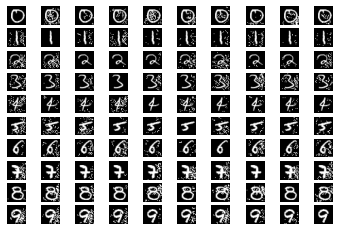

SystemExit: ignored

In [7]:
if __name__ == '__main__':
  flags.DEFINE_boolean('viz_enabled', VIZ_ENABLED,
                       'Visualize adversarial ex.')
  flags.DEFINE_integer('nb_epochs', NB_EPOCHS,
                       'Number of epochs to train model')
  flags.DEFINE_integer('batch_size', BATCH_SIZE, 'Size of training batches')
  flags.DEFINE_integer('source_samples', SOURCE_SAMPLES,
                       'Nb of test inputs to attack')
  flags.DEFINE_float('learning_rate', LEARNING_RATE,
                     'Learning rate for training')

  tf.app.run()